In [1]:
from utils import *

# N_nulls per volume rank

In [2]:
market_data = load_and_prepare_market_data().collect()
market_data.null_count()

date,symbol,price,volume,date_index,n_days_listed,volume_smoothed,volatility,cost_shorting,cost_transaction,cost_market_impact
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,47,47,0,0,16472,0,0,16472,218004


In [3]:
have_same_nulls(market_data, 'price', 'volume')

True

In [4]:
attrs = ['min', 'max', 'len']
(
    market_data
    .filter(pl.col('price').is_null())
    .group_by('symbol')
    .agg([getattr(pl.col('date'), attr)().alias(attr) for attr in attrs])
    .sort('symbol')
)

symbol,min,max,len
str,date,date,u32
"""CRVO""",2023-08-18,2023-09-21,24
"""ELVN""",2023-02-24,2023-02-24,1
"""ESGL""",2023-08-04,2023-08-04,1
"""JTAI""",2023-08-11,2023-08-11,1
"""LDWY""",2023-08-04,2023-08-04,1
"""LUXH""",2022-11-07,2022-11-07,1
"""NUKK""",2023-12-28,2024-01-16,12
"""PMGMU""",2023-08-22,2023-08-22,1
"""RCAT""",2002-03-26,2002-03-28,2


In [5]:
symbols_w_nulls = market_data.filter(pl.col('price').is_null()).select(keys[1]).unique()

In [6]:
max_formation_length = (
    pl.scan_parquet('./simus_with_more_shifts/index.parquet')
    .select(pl.col('formation_length').max())
    .collect()
    .item()
)
volume_rank = pl.col('volume_smoothed').rank(method='ordinal', descending=True).over(keys[0])

temp = (
    market_data
    .filter(pl.col('n_days_listed') >= max_formation_length)
    .with_columns(volume_rank=volume_rank)
)

In [7]:
attrs = ['min', 'max', 'median']
(
    temp
    .join(symbols_w_nulls, on=keys[1])
    .group_by(keys[1])
    .agg([getattr(pl.col('volume_rank'), attr)().alias(attr) for attr in attrs])
)

symbol,min,max,median
str,u32,u32,f64
"""CRVO""",376,3682,1542.0
"""LDWY""",48,3795,1119.0
"""JTAI""",371,3912,2962.0
"""TYGO""",902,3967,2755.5
"""NUKK""",1008,3920,3036.0
"""RCAT""",158,3297,1499.0
"""PMGMU""",2240,4071,3488.5
"""LUXH""",1242,3340,2222.0
"""ELVN""",299,3261,1914.0


In [8]:
get_consecutive_slices(
    market_data.join(symbols_w_nulls, on=keys[1]),
    keys[0], [keys[1]], 'price'
)

symbol,start_date,end_date
str,date,date
"""CRVO""",2008-05-23,2023-08-17
"""CRVO""",2023-09-22,2024-04-09
"""ELVN""",2020-03-12,2023-02-23
"""ELVN""",2023-02-27,2024-04-09
"""ESGL""",2022-04-07,2023-08-03
"""ESGL""",2023-08-07,2024-04-09
"""JTAI""",2021-10-01,2023-08-10
"""JTAI""",2023-08-14,2024-04-09
"""LDWY""",2000-01-03,2023-08-03


# Universe turnover

In [9]:
path_index = Path('./simus_with_more_shifts/index.parquet')
index = pl.read_parquet(path_index)

In [10]:
%%time
for params in index.iter_rows(named=True):
    pass

universe = get_universe_with_start_date(params)
params

CPU times: user 13.5 s, sys: 3 s, total: 16.5 s
Wall time: 3.9 s


{'formation_length': 126,
 't_max': 126,
 'n_stocks': 1000,
 'start_date': datetime.date(2001, 1, 2),
 'path': 'simus_with_more_shifts/353.parquet'}

<Figure size 900x500 with 0 Axes>

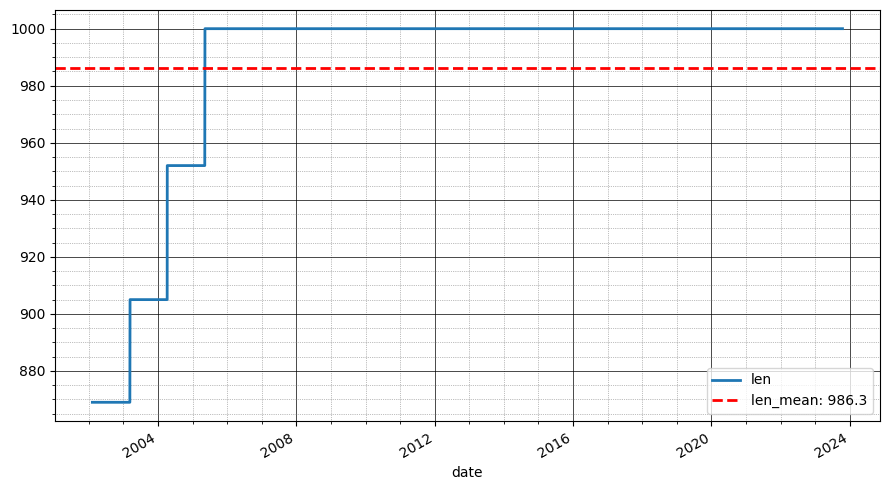

In [11]:
counts = universe.group_by('date', maintain_order=True).len()
plot_ts(counts, 'date', with_mean=True)

<Figure size 900x500 with 0 Axes>

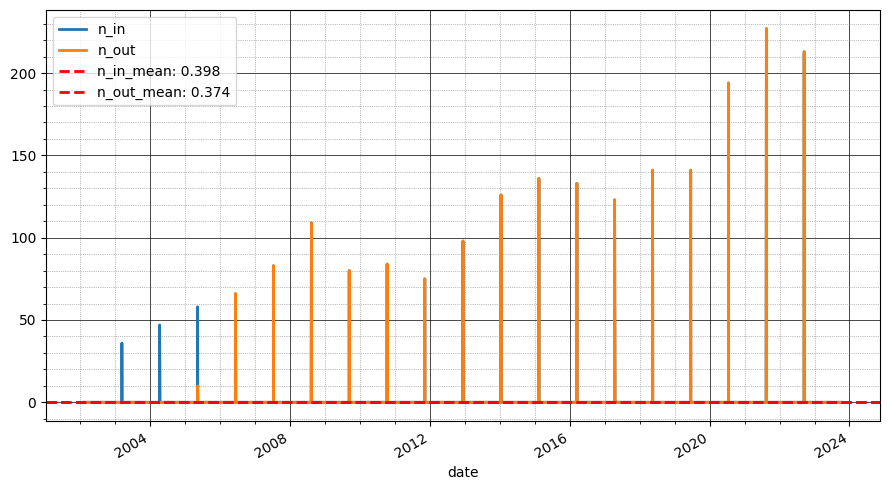

In [12]:
n_in_out = membership_turnover(universe, *keys)
plot_pd_frame(n_in_out.to_pandas().set_index(keys[0]).iloc[1:], with_mean=True)

<Figure size 900x500 with 0 Axes>

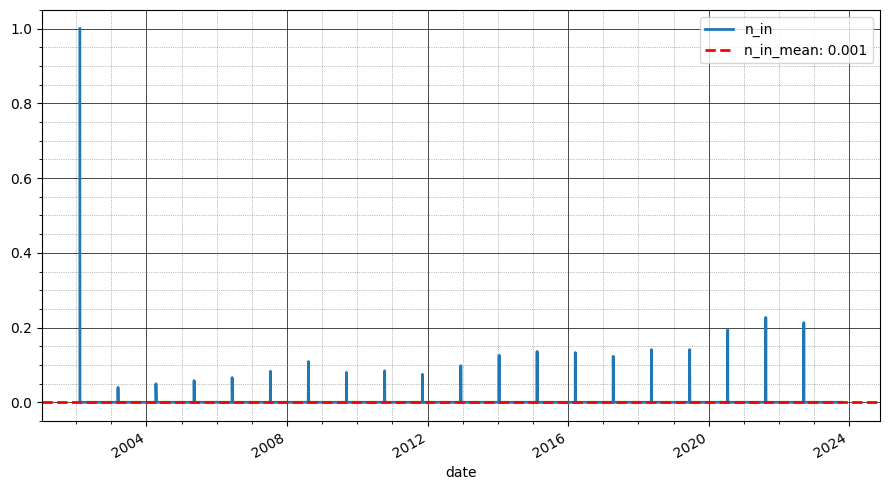

In [13]:
sub = (
    n_in_out
    .join(counts, on='date')
    .with_columns(pl.col('n_in', 'n_out') / pl.col('len'))
    .drop('len')
)
plot_ts(sub.select('date', 'n_in'), 'date', with_mean=True)

<Figure size 900x500 with 0 Axes>

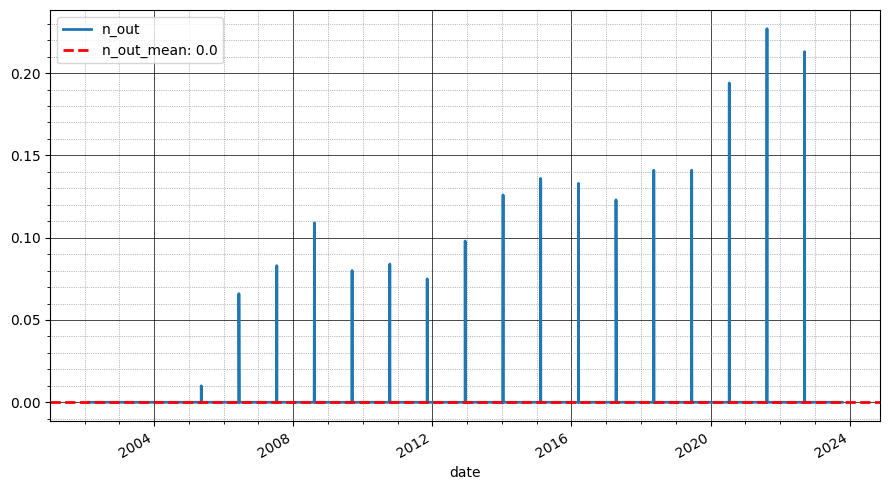

In [14]:
plot_ts(sub.select('date', 'n_out'), 'date', with_mean=True)

# Aggregated universe turnover

In [15]:
del params['start_date']
del params['path']
hyperparameter = params.copy()

In [16]:
paths = (
    index
    .join(pl.DataFrame(hyperparameter), on=list(hyperparameter))
    .get_column('path')
)
universes = pl.concat([
    read_data_one_run(path_run, path_index)[-1]
    for path_run in paths
])
universes.schema

OrderedDict([('date', Date),
             ('symbol', String),
             ('price', Float64),
             ('volume', Float64),
             ('volume_smoothed', Float64),
             ('batch', Int32),
             ('is_formation', Boolean),
             ('path', String)])

<Figure size 900x500 with 0 Axes>

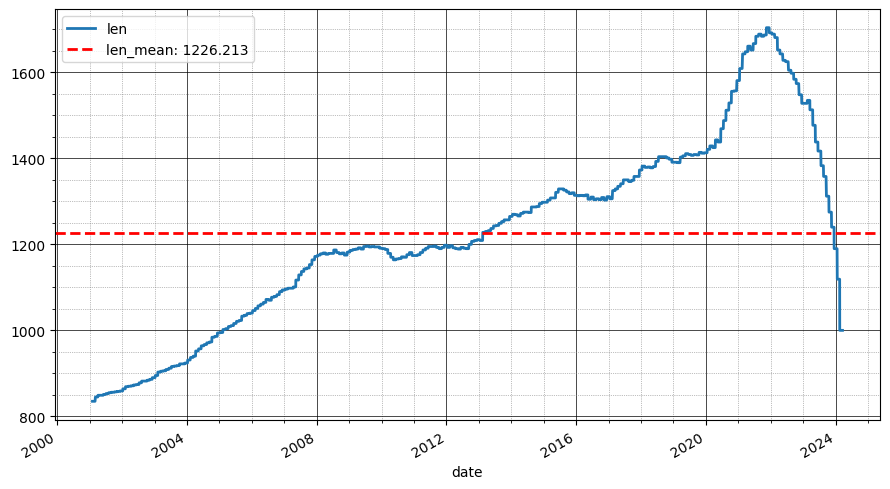

<Figure size 900x500 with 0 Axes>

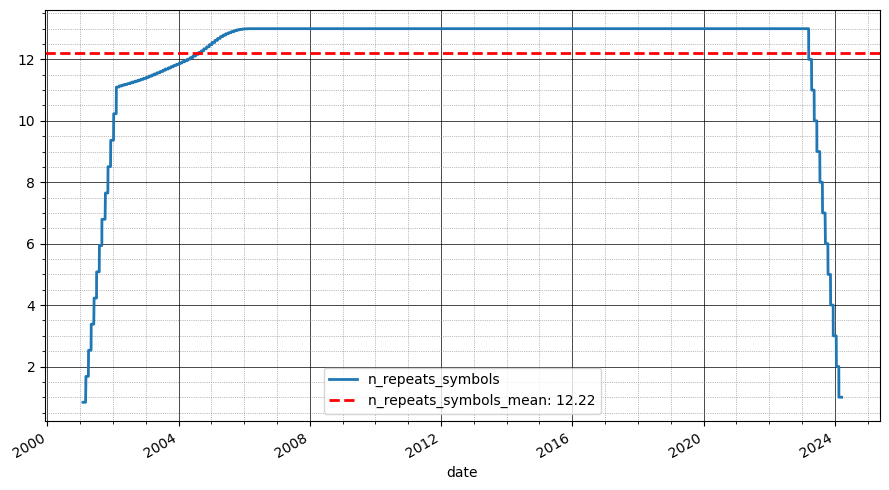

<Figure size 900x500 with 0 Axes>

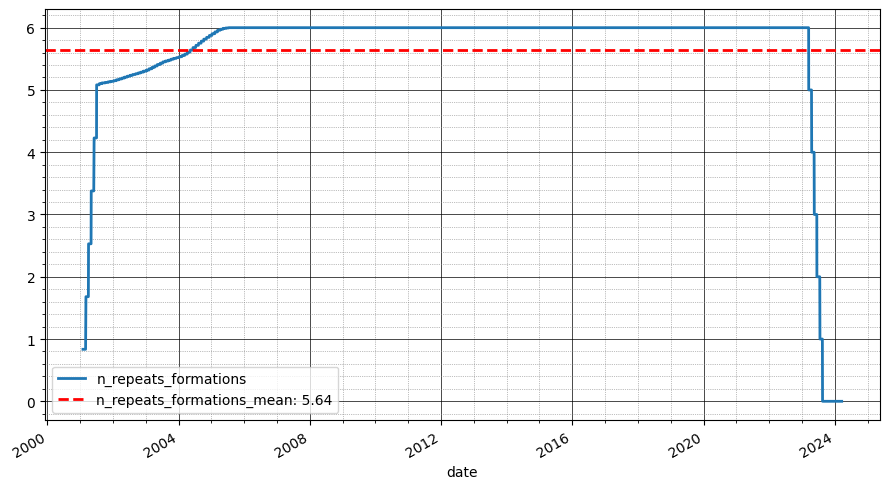

<Figure size 900x500 with 0 Axes>

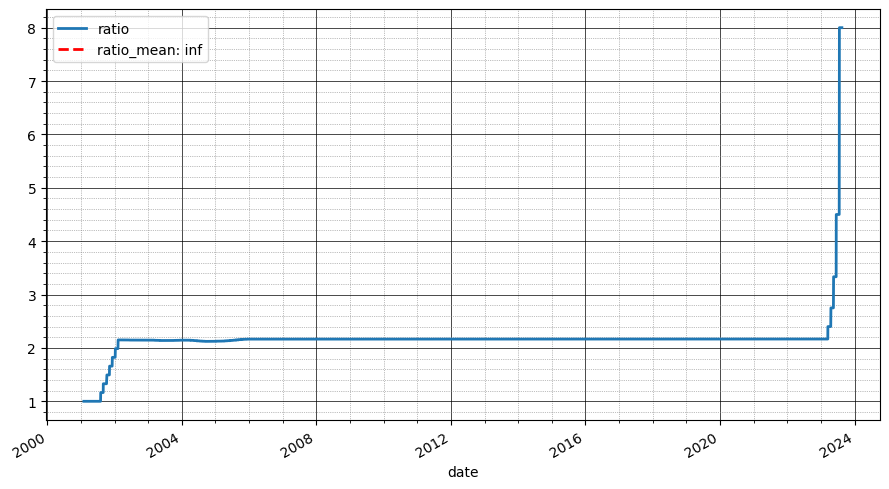

In [17]:
counts = (
    universes
    .group_by(keys[0])
    .agg([
        pl.col(keys[1]).n_unique().alias('len'),
        (pl.col(keys[1]).len() / 1000).alias('n_repeats_symbols'),
        (pl.col('is_formation').sum() / 1000).alias('n_repeats_formations'),
    ])
    .with_columns(ratio=pl.col('n_repeats_symbols') / pl.col('n_repeats_formations'))
    .sort(keys[0])
    .collect()
)
for col in counts.drop(keys[0]):
    plot_ts(counts.select(keys[0], col), keys[0], with_mean=True)

<Figure size 900x500 with 0 Axes>

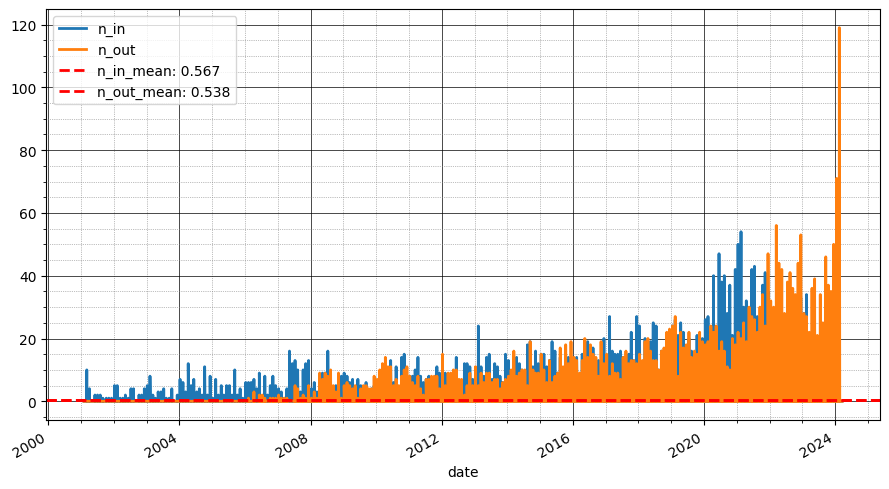

In [18]:
universe = universes.select(keys).unique().sort(keys[0])
n_in_out = membership_turnover(universe.collect(), *keys)
plot_pd_frame(n_in_out.to_pandas().set_index(keys[0]).iloc[1:], with_mean=True)

<Figure size 900x500 with 0 Axes>

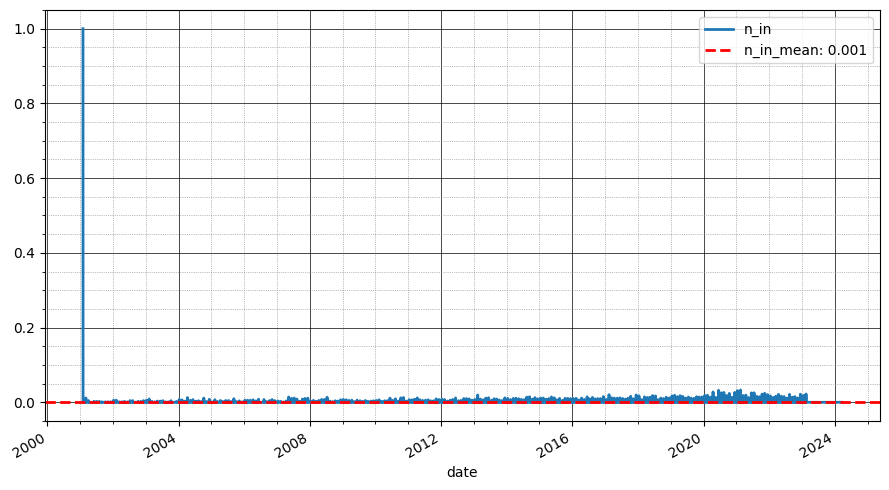

In [19]:
sub = (
    n_in_out
    .join(counts, on=keys[0])
    .with_columns(pl.col('n_in', 'n_out') / pl.col('len'))
    .drop('len')
)
plot_ts(sub.select(keys[0], 'n_in'), keys[0], with_mean=True)

<Figure size 900x500 with 0 Axes>

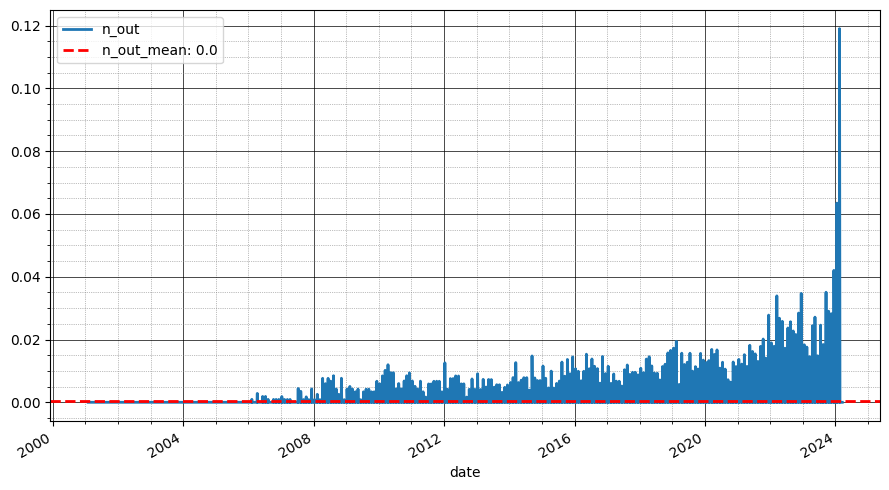

In [20]:
plot_ts(sub.select(keys[0], 'n_out'), keys[0], with_mean=True)